In [1]:
%cd ../..
%pwd
import sys, os, json
sys.path.append(os.path.abspath("src"))

from c_cluster_analysis.logprobs.sentence_level_inference_quick import (
    load_model_and_tokenizer, run_batch_from_files
)

input_int = 1001
input_count = str(input_int)
verbnonverb = "unverb"
MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
model, tok, _, _ = load_model_and_tokenizer(MODEL)

data_dir = "data/mmlu"
output_dir = "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B"
attn_dir = output_dir + "/attn"

questions_file = data_dir + "/input_mcq_data.json"
hints_file     = data_dir + "/hints_sycophancy.json" # can be None!
whitelist_file = output_dir + "/filter/"+verbnonverb+"_ids_"+input_count+"_sycophancy.json"
#whitelist_file = output_dir + "/filter/"+verbnonverb+"_ids_2001.json"

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


In [2]:
# print the contents of the whitelist file
with open(whitelist_file, "r") as f:
    print(f.read())

[
  43,
  58,
  81,
  83,
  93,
  94,
  102,
  104,
  112,
  115,
  140,
  147,
  217,
  221,
  233,
  241,
  246,
  265,
  279,
  284,
  299,
  354,
  384,
  404,
  410,
  415,
  445,
  448,
  453,
  455,
  462,
  469,
  481,
  484,
  510,
  543,
  549,
  574,
  581,
  591,
  632,
  642,
  644,
  659,
  667,
  685,
  695,
  698,
  712,
  726,
  729,
  778,
  779,
  789,
  790,
  806,
  828,
  829,
  836,
  858,
  885,
  886,
  903,
  915,
  918,
  949,
  950,
  957,
  967,
  975,
  995
]


In [ ]:
#out_file       = "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/attn/sentence_level_results_sycophancy_unverbalized_ids.json"

hint_type = "sycophancy"
run_batch_from_files(
    model, tok,
    questions_file=questions_file,
    hints_file=hints_file,
    output_file=attn_dir+"/"+hint_type+"_"+verbnonverb+"_"+input_count+".json",
    whitelist_file=whitelist_file,
    max_questions=input_int,
    max_new_tokens=2048,
)

print("Done")

questions: 100%|██████████| 71/71 [19:11<00:00, 16.22s/q, qid=995, sent=25] 

Done


In [4]:
hints_file     = None

hint_type = "none"
run_batch_from_files(
    model, tok,
    questions_file=questions_file,
    hints_file=hints_file,
    output_file=attn_dir+"/"+hint_type+"_"+verbnonverb+"_"+input_count+".json",
    whitelist_file=whitelist_file,
    max_questions=input_int,
    max_new_tokens=2048,
)

print("Done")

questions:   1%|▏         | 1/71 [00:01<01:40,  1.44s/q]

questions: 100%|██████████| 71/71 [18:17<00:00, 15.46s/q, qid=995, sent=125]

Done


In [5]:
# print the contents of the whitelist file
with open(whitelist_file, "r") as f:
    print(f.read())


[
  43,
  58,
  81,
  83,
  93,
  94,
  102,
  104,
  112,
  115,
  140,
  147,
  217,
  221,
  233,
  241,
  246,
  265,
  279,
  284,
  299,
  354,
  384,
  404,
  410,
  415,
  445,
  448,
  453,
  455,
  462,
  469,
  481,
  484,
  510,
  543,
  549,
  574,
  581,
  591,
  632,
  642,
  644,
  659,
  667,
  685,
  695,
  698,
  712,
  726,
  729,
  778,
  779,
  789,
  790,
  806,
  828,
  829,
  836,
  858,
  885,
  886,
  903,
  915,
  918,
  949,
  950,
  957,
  967,
  975,
  995
]


In [8]:
# %% [markdown]
### Load data-frames + add answer metadata  (replaces your previous block)

# %%
import json, pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

#input_count = "1001"
# ---------------------------------------------------------------------
# file paths  – change these three if your filenames differ
# ---------------------------------------------------------------------
QUESTIONS_FILE       = data_dir + "/input_mcq_data.json"
VERIFIED_ANS_FILE    = data_dir + "/DeepSeek-R1-Distill-Llama-8B/sycophancy/verification_with_"+input_count+".json"
HINT_ANALYSIS_FILE   = data_dir + "/hints_sycophancy.json"

WITH_HINT_FILE       = output_dir + "/attn/sycophancy_"+verbnonverb+"_"+input_count+".json"
WITHOUT_HINT_FILE    = output_dir + "/attn/none_"+verbnonverb+"_"+input_count+".json"
ANNOT_WITH_HINT      = output_dir + "/confidence/sycophancy_"+verbnonverb+"_"+input_count+".json"
ANNOT_WITHOUT_HINT   = output_dir + "/confidence/none_"+verbnonverb+"_"+input_count+".json"

# ---------------------------------------------------------------------
# helper: read MC-question file (gives correct option per qid)
# ---------------------------------------------------------------------
def _load_correct_map(path: str) -> dict[int, str]:
    data = json.load(open(path, encoding="utf-8"))
    if isinstance(data, dict):            # (rare) dict keyed by qid‐str
        return {int(k): v["correct"] for k, v in data.items()}
    return {d["question_id"]: d["correct"] for d in data}

# helper: read verified-answer file (model’s chosen option per qid)
def _load_verified_map(path: str) -> dict[int, str]:
    data = json.load(open(path, encoding="utf-8"))
    return {d["question_id"]: d["verified_answer"] for d in data}

correct_map  = _load_correct_map(QUESTIONS_FILE)
verified_map = _load_verified_map(VERIFIED_ANS_FILE)

# ---------------------------------------------------------------------
# 0.  Sentence-level dataframe loader (unchanged)
# ---------------------------------------------------------------------
def load_sentence_df(path: str) -> pd.DataFrame:
    with open(path, encoding="utf-8") as f:
        raw = json.load(f)

    rows = []
    for entry in raw:
        qid = entry["question_id"]
        for s in entry["sentences"]:
            rows.append({
                "question_id"          : qid,
                "sentence_id"          : s["sentence_id"],
                "sentence"             : s["sentence"],
                "avg_att_prompt"       : s["avg_att_prompt"],
                "avg_att_prompt_only"  : s.get("avg_att_prompt_only"),
                "avg_att_hint_only"    : s.get("avg_att_hint_only"),
                "answer_logits_dict"   : s["answer_logits"],
                "answer_probs_dict"    : s["answer_probs"],
            })
    df = pd.DataFrame(rows)

    # explode dicts into separate columns
    for col in ("answer_logits_dict", "answer_probs_dict"):
        expanded = pd.json_normalize(df[col])
        expanded.columns = [f"{col.split('_dict')[0]}_{c}" for c in expanded]
        df = pd.concat([df, expanded], axis=1)

    return df.drop(columns=["answer_logits_dict", "answer_probs_dict"])


# ---------------------------------------------------------------------
# 1.  Annotation dataframe loader (unchanged)
# ---------------------------------------------------------------------
CATEGORY_COLUMNS = [
    "problem_restating",
    "knowledge_augmentation",
    "assumption_validation",
    "logical_deduction",
    "option_elimination",
    "uncertainty_or_certainty_expression",
    "backtracking",
    "forward_planning",
    "decision_confirmation",
    "answer_reporting",
    "option_restating",
    "other",
]

def load_annotation_df(path: str) -> pd.DataFrame:
    with open(path, encoding="utf-8") as f:
        raw = json.load(f)

    rows = []
    for entry in raw:
        qid = entry["question_id"]
        for ann in entry["annotations"]:
            best_cat = max(CATEGORY_COLUMNS, key=lambda c: ann[c])
            rows.append({"question_id": qid,
                         "sentence_id": ann["sentence_id"],
                         "category":    best_cat})
    return pd.DataFrame(rows)


# ---------------------------------------------------------------------
# 2.  Merge & add derived metadata
# ---------------------------------------------------------------------
def merge_sentences_and_categories(sent_df, annot_df):
    return (sent_df.merge(annot_df,
                          on=["question_id", "sentence_id"],
                          how="left"))

def add_answer_metadata(df, correct_map, verified_map):
    """
    Adds:
      • hint_option       – the option the *model* actually chose
      • is_correct_option – True if that option is the ground-truth answer
    """
    df = df.copy()
    df["hint_option"]       = df["question_id"].map(verified_map)
    df["is_correct_option"] = df.apply(
        lambda r: r["hint_option"] == correct_map.get(r["question_id"]), axis=1
    )
    return df.dropna(subset=["hint_option"])   # keep only rows with model answer


with_df = merge_sentences_and_categories(
              load_sentence_df(WITH_HINT_FILE),
              load_annotation_df(ANNOT_WITH_HINT)
          )
with_df = add_answer_metadata(with_df, correct_map, verified_map)

without_df = merge_sentences_and_categories(
                load_sentence_df(WITHOUT_HINT_FILE),
                load_annotation_df(ANNOT_WITHOUT_HINT)
            )
without_df = add_answer_metadata(without_df, correct_map, verified_map)

print("with-hint rows   :", len(with_df))
print("without-hint rows:", len(without_df))


with-hint rows   : 1619
without-hint rows: 1822


In [2]:
import json, ast, os, itertools
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

WITH_HINT_FILE      = out_sycophancy_file
WITHOUT_HINT_FILE   = out_none_file
ANNOT_WITH_HINT     = "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/filtered_71_unverbalized_annotations_confidence_sycophancy.json"
ANNOT_WITHOUT_HINT  = "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/filtered_71_unverbalized_annotations_confidence_none.json"
HINT_META_FILE      = "data/mmlu/hints_sycophancy.json"

def load_sentence_df(path: str) -> pd.DataFrame:
    with open(path, encoding="utf-8") as f:
        raw = json.load(f)

    rows = []
    for entry in raw:
        qid = entry["question_id"]
        for s in entry["sentences"]:
            rows.append({
                "question_id"          : qid,
                "sentence_id"          : s["sentence_id"],
                "sentence"             : s["sentence"],
                "avg_att_prompt"       : s["avg_att_prompt"],
                "avg_att_prompt_only"  : s.get("avg_att_prompt_only"),
                "avg_att_hint_only"    : s.get("avg_att_hint_only"),
                "answer_logits_dict"   : s["answer_logits"],
                "answer_probs_dict"    : s["answer_probs"],
            })
    df = pd.DataFrame(rows)
    # logits / prob dicts into individual columns for A,B,C,D
    for col in ("answer_logits_dict","answer_probs_dict"):
        expanded = pd.json_normalize(df[col])
        expanded.columns = [f"{col.split('_dict')[0]}_{c}" for c in expanded]
        df = pd.concat([df, expanded], axis=1)
    return df.drop(columns=["answer_logits_dict","answer_probs_dict"])


CATEGORY_COLUMNS = [
    "problem_restating",
    "knowledge_augmentation",
    "assumption_validation",
    "logical_deduction",
    "option_elimination",
    "uncertainty_or_certainty_expression",
    "backtracking",
    "forward_planning",
    "decision_confirmation",
    "answer_reporting",
    "option_restating",
    "other",
]

def load_annotation_df(path: str) -> pd.DataFrame:
    with open(path, encoding="utf-8") as f:
        raw = json.load(f)

    rows = []
    for entry in raw:
        qid = entry["question_id"]
        for ann in entry["annotations"]:
            # category with maximum score
            cat_name = max(CATEGORY_COLUMNS, key=lambda c: ann[c])
            rows.append({
                "question_id" : qid,
                "sentence_id" : ann["sentence_id"],
                "category"    : cat_name,
            })
    return pd.DataFrame(rows)

def merge_sentences_and_categories(sent_df, annot_df):
    return (sent_df.merge(annot_df,
                          on=["question_id","sentence_id"],
                          how="left"))

def add_hint_metadata(df, hint_file):
    if hint_file is None or not Path(hint_file).exists():
        return df
    hint_map = {h["question_id"]: h for h in json.load(open(hint_file, encoding="utf-8"))}
    return df.assign(
        hint_option       = df["question_id"].map(lambda q: hint_map.get(q, {}).get("hint_option")),
        is_correct_option = df["question_id"].map(lambda q: hint_map.get(q, {}).get("is_correct_option")),
    ).dropna(subset=["hint_option"])


In [9]:
with_df  = merge_sentences_and_categories(
              load_sentence_df(WITH_HINT_FILE),
              load_annotation_df(ANNOT_WITH_HINT))
with_df  = add_hint_metadata(with_df, HINT_META_FILE)

without_df = merge_sentences_and_categories(
                load_sentence_df(WITHOUT_HINT_FILE),
                load_annotation_df(ANNOT_WITHOUT_HINT))

print("with-hint rows   :", len(with_df))
print("without-hint rows:", len(without_df))

with_df.head(3)

NameError: name 'add_hint_metadata' is not defined

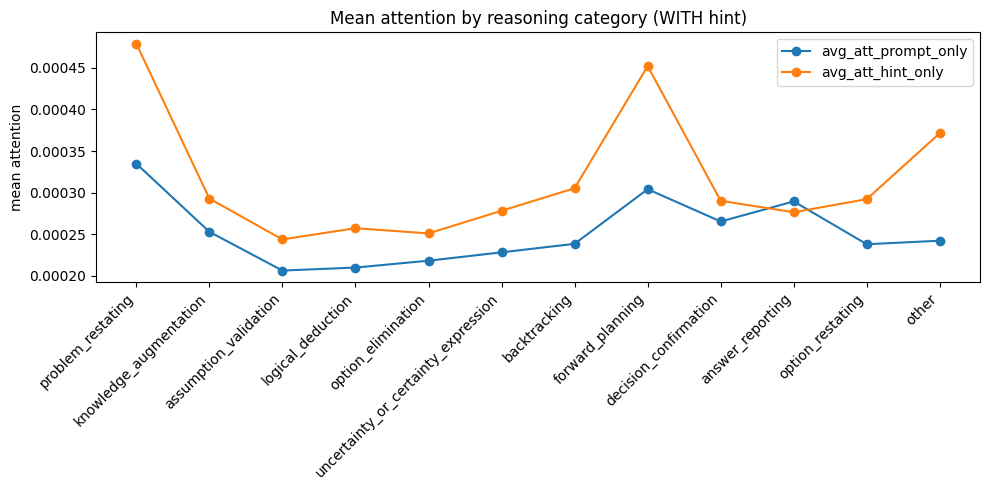

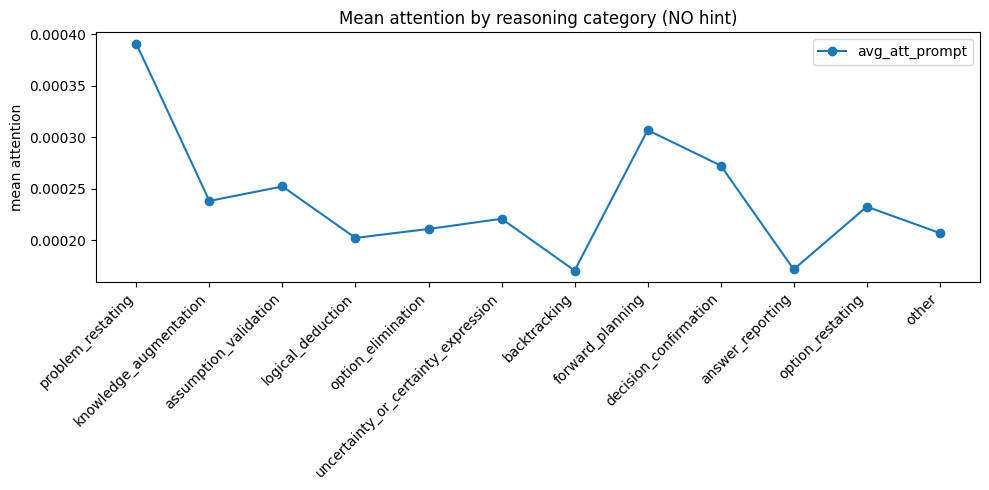

In [10]:
def plot_attention(df, title_suffix="", use_hint_cols=False):
    fig, ax = plt.subplots(figsize=(10,5))
    metric_cols = ["avg_att_prompt_only" if use_hint_cols else "avg_att_prompt"]
    if use_hint_cols:
        metric_cols = ["avg_att_prompt_only", "avg_att_hint_only"]
    else:
        metric_cols = ["avg_att_prompt"]

    metrics = {m: [] for m in metric_cols}
    labels  = []

    for cat in CATEGORY_COLUMNS:
        sub = df[df["category"] == cat]
        if sub.empty:
            continue
        labels.append(cat)
        for m in metric_cols:
            metrics[m].append(sub[m].mean())

    xpos = range(len(labels))
    for m in metric_cols:
        ax.plot(xpos, metrics[m], marker="o", label=m)

    ax.set_xticks(xpos); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("mean attention")
    ax.set_title(f"Mean attention by reasoning category {title_suffix}")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_attention(with_df,    "(WITH hint)",   use_hint_cols=True)
plot_attention(without_df, "(NO hint)",     use_hint_cols=False)


In [11]:
for correct_flag, grp_df in with_df.groupby("is_correct_option"):
    label = "TRUE hints" if correct_flag else "FALSE hints"
    fig, ax = plt.subplots(figsize=(10,5))
    cats = sorted(grp_df["category"].unique(), key=CATEGORY_COLUMNS.index)
    for cat in cats:
        sub = grp_df[grp_df["category"]==cat]
        ax.scatter([cat]*len(sub), sub["hinted_logit"], marker="o")
        ax.scatter([cat]*len(sub), sub["other_max_logit"], marker="x")
    ax.set_ylabel("answer logits")
    ax.set_title(f"Hinted vs max-other logits per category ({label})")
    ax.set_xticks(range(len(cats))); ax.set_xticklabels(cats, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


KeyError: 'is_correct_option'

/tmp/ipykernel_18089/217604469.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([c for c,_ in corrs], rotation=45, ha="right")


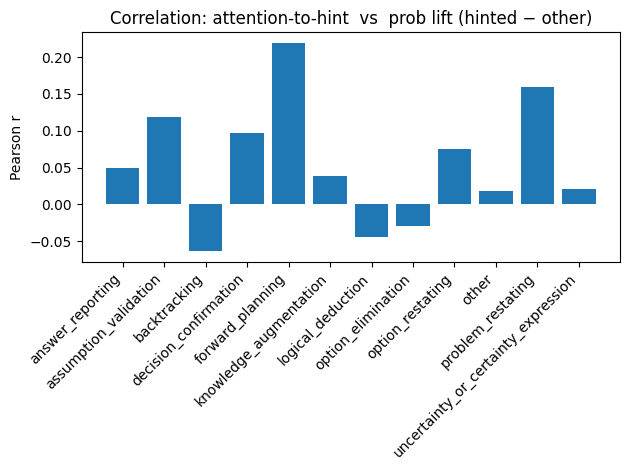

In [16]:
import numpy as np
corrs = []
for cat, sub in with_df.groupby("category"):
    if sub["avg_att_hint_only"].notna().sum() < 5:        # tiny groups – skip
        continue
    corr = np.corrcoef(sub["avg_att_hint_only"],
                       sub["hinted_prob"] - sub["other_max_prob"])[0,1]
    corrs.append((cat, corr))

fig, ax = plt.subplots()
ax.bar([c for c,_ in corrs], [v for _,v in corrs])
ax.set_ylabel("Pearson r")
ax.set_xticklabels([c for c,_ in corrs], rotation=45, ha="right")
ax.set_title("Correlation: attention-to-hint  vs  prob lift (hinted − other)")
plt.tight_layout()
plt.show()


ValueError: nan is not in list

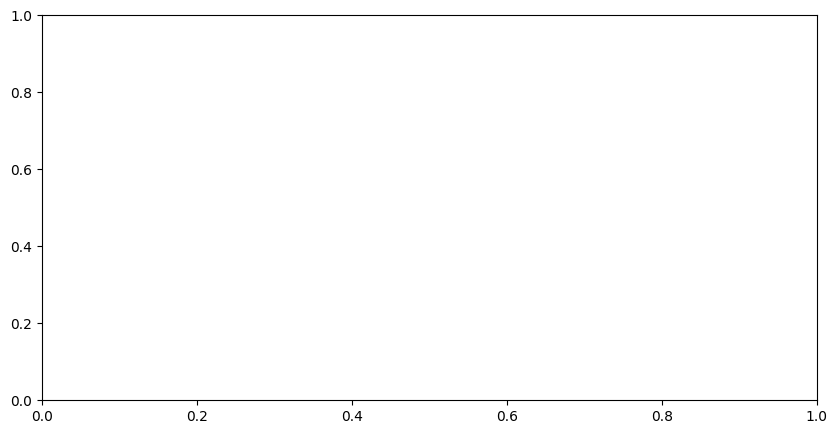

In [9]:
def enrich_probs(df):
    """adds columns hinted_prob, other_max_prob (and same for logits)"""
    def hinted(row, base):
        return row[f"{base}_{row['hint_option']}"]
    def other_max(row, base):
        vals = [row[f"{base}_{l}"] for l in ("A","B","C","D") if l!=row['hint_option']]
        return max(vals)

    df["hinted_prob"]     = df.apply(lambda r: hinted(r,"answer_probs"),  axis=1)
    df["other_max_prob"]  = df.apply(lambda r: other_max(r,"answer_probs"), axis=1)
    df["hinted_logit"]    = df.apply(lambda r: hinted(r,"answer_logits"), axis=1)
    df["other_max_logit"] = df.apply(lambda r: other_max(r,"answer_logits"), axis=1)
    return df

with_df = enrich_probs(with_df)

# split correct / incorrect hints
for correct_flag, grp_df in with_df.groupby("is_correct_option"):
    label = "TRUE hints" if correct_flag else "FALSE hints"
    fig, ax = plt.subplots(figsize=(10,5))
    cats = sorted(grp_df["category"].unique(), key=CATEGORY_COLUMNS.index)
    for cat in cats:
        sub = grp_df[grp_df["category"]==cat]
        ax.scatter([cat]*len(sub), sub["hinted_prob"], marker="o")
        ax.scatter([cat]*len(sub), sub["other_max_prob"], marker="x")
    ax.set_ylabel("answer probability")
    ax.set_title(f"Hinted vs max-other probability per category ({label})")
    ax.set_xticks(range(len(cats))); ax.set_xticklabels(cats, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [10]:
# %% [markdown]
### Diagnostics – missing/NaN category labels

# %%
import pandas as pd, numpy as np

def category_diagnostics(df: pd.DataFrame, name: str = "df"):
    print(f"\n─── Diagnostics for **{name}** ───")
    total_rows   = len(df)
    nan_rows     = df["category"].isna().sum()
    nan_pct      = nan_rows / total_rows if total_rows else 0

    print(f"• {nan_rows}/{total_rows} rows "
          f"({nan_pct:.1%}) have **no category annotation**")

    if nan_rows:
        print("\n  NaN rows broken down by is_correct_option:")
        print(df[df["category"].isna()]
              .groupby("is_correct_option")
              .size()
              .rename("rows"))

    print("\n  Distribution of *valid* categories:")
    counts = (df["category"]
              .dropna()
              .value_counts()
              .reindex(CATEGORY_COLUMNS, fill_value=0))
    display(counts.to_frame("rows"))

# run on both data-frames
category_diagnostics(with_df,    "with_df (hinted)")
category_diagnostics(without_df, "without_df (no hint)")



─── Diagnostics for **with_df (hinted)** ───
• 771/2875 rows (26.8%) have **no category annotation**

  NaN rows broken down by is_correct_option:
is_correct_option
False    597
True     174
Name: rows, dtype: int64

  Distribution of *valid* categories:


,rows
category,
problem_restating,241
knowledge_augmentation,392
assumption_validation,23
logical_deduction,551
option_elimination,111
uncertainty_or_certainty_expression,205
backtracking,29
forward_planning,122
decision_confirmation,25



─── Diagnostics for **without_df (no hint)** ───
• 727/3047 rows (23.9%) have **no category annotation**

  NaN rows broken down by is_correct_option:


KeyError: 'is_correct_option'

In [2]:
# %%
import json
from pathlib import Path
import pandas as pd

# ------------------------------------------------------------------
# 1.  -------  paths  ---------------------------------------------
# ------------------------------------------------------------------
MCQ_FILE          = "data/mmlu/input_mcq_data.json"             # has the 'correct' field
VERIFIED_FILE     = "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/verification_with_71.json"
HINT_VERIF_FILE   = "data/mmlu/hints_sycophancy.json"           # has 'hint_option' information

# ------------------------------------------------------------------
# 2.  -------  helper to build lookup tables  ---------------------
# ------------------------------------------------------------------
def _load_mcq_correct(path)->dict[int,str]:
    with open(path, encoding="utf-8") as f:
        raw = json.load(f)
    return {int(r["question_id"]): r["correct"] for r in raw}

def _load_verified_answers(path)->dict[int,str]:
    with open(path, encoding="utf-8") as f:
        raw = json.load(f)
    return {int(r["question_id"]): r["verified_answer"] for r in raw}

def _load_hint_options(path)->dict[int,str]:
    if not Path(path).exists():
        return {}
    with open(path, encoding="utf-8") as f:
        raw = json.load(f)
    # file may contain entries without 'hint_option' – be defensive
    return {int(r["question_id"]): r.get("hint_option") for r in raw if "hint_option" in r}

MCQ_CORRECT   = _load_mcq_correct(MCQ_FILE)
VERIFIED_MAP  = _load_verified_answers(VERIFIED_FILE)
HINT_OPTION   = _load_hint_options(HINT_VERIF_FILE)

# ------------------------------------------------------------------
# 3.  -------  attach columns  ------------------------------------
# ------------------------------------------------------------------
def add_option_meta(df: pd.DataFrame) -> pd.DataFrame:
    df = df.assign(
        correct_option  = df["question_id"].map(MCQ_CORRECT),
        verified_option = df["question_id"].map(VERIFIED_MAP),
        hint_option     = df["question_id"].map(HINT_OPTION),
    )
    # Correctness of the *hinted* option (falls back to NaN if either side missing)
    df["is_correct_option"] = df["hint_option"] == df["correct_option"]
    return df

with_df    = add_option_meta(with_df)
without_df = add_option_meta(without_df)

# ------------------------------------------------------------------
# 4.  -------  sanity-check / quantify  ---------------------------
# ------------------------------------------------------------------
def flag_report(df: pd.DataFrame, name:str):
    print(f"\n── {name} ──")
    for col in ["hint_option", "correct_option", "verified_option", "is_correct_option"]:
        miss = df[col].isna().sum()
        print(f"{col:16s}: missing {miss:4d}  "
              f"({miss/len(df):5.1%})")
    if "is_correct_option" in df.columns:
        print("\nCorrectness split:")
        print(df.groupby("is_correct_option").size().rename("rows"))

flag_report(with_df,    "with_df")
flag_report(without_df, "without_df")


FileNotFoundError: [Errno 2] No such file or directory: 'c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/verification_with_71.json'